# Simple RNN

In ths notebook, we're going to train a simple RNN to do **time-series prediction**. Given some set of input data, it should be able to generate a prediction for the next time step!
<img src='assets/time_prediction.png' width=40% />

> * First, we'll create our data
* Then, define an RNN in PyTorch
* Finally, we'll train our network and see how it performs

### Import resources and create data 

In [1]:
import torch
from torch import nn
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

# Data

We will look at a clean sinus signal at first and investigate the memorysation effect of a LSTM there. We want to predict the next time step in the future given some past. We will move to more complex examples later.

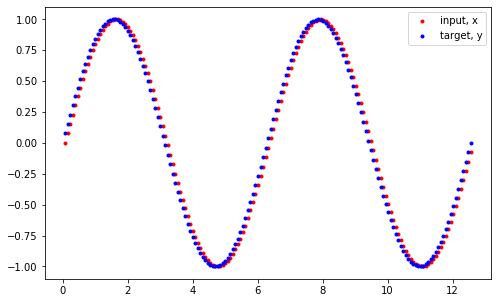

In [2]:
plt.figure(figsize=(8,5))

# how many time steps/data pts are in one batch of data
seq_length = 40

# generate evenly spaced data pts
times_pi = 4
shown_seq_length = times_pi*(seq_length + 1)
time_steps = np.linspace(0, times_pi*np.pi, shown_seq_length)
data = np.sin(time_steps)
data.resize((shown_seq_length, 1)) # size becomes (seq_length+1, 1), adds an input_size dimension

x = data[:-1] # all but the last piece of data
y = data[1:] # all but the first

# display the data
plt.plot(time_steps[1:], x, 'r.', label='input, x') # x
plt.plot(time_steps[1:], y, 'b.', label='target, y') # y

plt.legend(loc='best')
plt.show()

---
## Define the LSTM

Next, we define an RNN in PyTorch. We'll use `nn.LSTM` to create an RNN (LSTM) layer, then we'll add a last, fully-connected layer to get the output size that we want. `nn.LSTM` takes similar parameters as a vanillia RNN:
* **input_size** - the size of the input
* **hidden_dim** - the number of features in the RNN output and in the hidden state
* **n_layers** - the number of layers that make up the RNN, typically 1-3; greater than 1 means that you'll create a stacked RNN
* **dropout** - a dropout probability for each of the gates (also known as AWD-LSTM)
* **batch_first** - whether or not the input/output of the RNN will have the batch_size as the first dimension (batch_size, seq_length, hidden_dim)

Take a look at the [LSTM documentation](https://pytorch.org/docs/stable/nn.html#lstm) to read more.

In [3]:
# check if GPU is available
train_on_gpu = torch.cuda.is_available()
if(train_on_gpu):
    print('Training on GPU!')
else: 
    print('No GPU available, training on CPU; consider making n_epochs very small.')

No GPU available, training on CPU; consider making n_epochs very small.


In [4]:
class SinusoidLSTM(nn.Module):
    
    def __init__(self, input_size, output_size, n_hidden=256, n_layers=2,
                               drop_prob=0.5, lr=0.001):
        super().__init__()
        self.drop_prob = drop_prob
        self.n_layers = n_layers
        self.n_hidden = n_hidden
        self.lr = lr
        
        # creating character dictionaries
        self.input_size = input_size
        
        ## TODO: define the layers of the model
        self.lstm = nn.LSTM(input_size, n_hidden, n_layers, 
                            dropout=drop_prob, batch_first=True)
        #self.dropout = nn.Dropout(drop_prob)
        self.fc = nn.Linear(n_hidden, output_size)
      
    
    def forward(self, x, hidden):
        ''' Forward pass through the network. 
            These inputs are x, and the hidden/cell state `hidden`. '''
        
        batch_size, sequence_length, input_dim = x.shape
        out, hidden = self.lstm(x, hidden)
        #out = self.dropout(out)
        out = out.contiguous().view(batch_size*sequence_length, self.n_hidden)
        out = self.fc(out)
        
        # return the final output and the hidden state
        return out, hidden
    
    
    def init_hidden(self, batch_size):
        ''' Initializes hidden state '''
        # Create two new tensors with sizes n_layers x batch_size x n_hidden,
        # initialized to zero, for hidden state and cell state of LSTM
        weight = next(self.parameters()).data
        
        if (train_on_gpu):
            hidden = (weight.new(self.n_layers, batch_size, self.n_hidden).zero_().cuda(),
                  weight.new(self.n_layers, batch_size, self.n_hidden).zero_().cuda())
        else:
            hidden = (weight.new(self.n_layers, batch_size, self.n_hidden).zero_(),
                      weight.new(self.n_layers, batch_size, self.n_hidden).zero_())
        
        return hidden
        

---
## Training the RNN

Next, we'll instantiate an RNN with some specified hyperparameters. Then train it over a series of steps, and see how it performs.

In [5]:
# decide on hyperparameters
input_size=1 
output_size=1
hidden_dim=8
n_layers=1

# instantiate an RNN
lstm = SinusoidLSTM(input_size, output_size, hidden_dim, n_layers)
print(lstm)

SinusoidLSTM(
  (lstm): LSTM(1, 8, batch_first=True, dropout=0.5)
  (fc): Linear(in_features=8, out_features=1, bias=True)
)


/home/jsimon/anaconda3/envs/interpretable-time-series/lib/python3.7/site-packages/torch/nn/modules/rnn.py:51: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.5 and num_layers=1
  "num_layers={}".format(dropout, num_layers))


### Loss and Optimization

This is a regression problem: can we train an RNN to accurately predict the next data point, given a current data point?

>* The data points are coordinate values, so to compare a predicted and ground_truth point, we'll use a regression loss: the mean squared error.
* It's typical to use an Adam optimizer for recurrent models.

In [6]:
# MSE loss and Adam optimizer with a learning rate of 0.01
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(lstm.parameters(), lr=0.001) 

### Defining the training function

This function takes in an rnn, a number of steps to train for, and returns a trained rnn. This function is also responsible for displaying the loss and the predictions, every so often.

#### Hidden State

Pay close attention to the hidden state, here:
* Before looping over a batch of training data, the hidden state is initialized
* After a new hidden state is generated by the rnn, we get the latest hidden state, and use that as input to the rnn for the following steps

In [7]:
# train the RNN
def train(rnn, batch_size, clip, n_steps, print_every):
    
    # initialize the hidden state
    hidden = rnn.init_hidden(4)    
    
    for batch_i, step in enumerate(range(n_steps)):
        # defining the training data 
        computed_seq_length = batch_size*(seq_length + 1)
        time_steps = np.linspace(step * np.pi, (step+batch_size)*np.pi, computed_seq_length).reshape(batch_size, (seq_length + 1))
        data = np.sin(time_steps)
        data.resize((batch_size, (seq_length + 1), 1)) # input_size=1
        #print(data.shape)

        x = data[:, :-1, :]
        y = data[:, 1:, :].reshape(batch_size*seq_length,)
        #print(x.shape)
        #print(y.shape)
        
        # convert data into Tensors
        x_tensor = torch.Tensor(x)
        y_tensor = torch.Tensor(y)

        # outputs from the rnn
        prediction, hidden = rnn(x_tensor, hidden)

        ## Representing Memory ##
        # make a new variable for hidden and detach the hidden state from its history
        # this way, we don't backpropagate through the entire history
        hidden = tuple([each.data for each in hidden])

        # calculate the loss
        #print(prediction.shape)
        #print(prediction.squeeze().shape)
        #print(y_tensor.shape)
        loss = criterion(prediction.squeeze(), y_tensor)
        # zero gradients
        optimizer.zero_grad()
        # perform backprop and update weights
        loss.backward()
        nn.utils.clip_grad_norm_(rnn.parameters(), clip)
        optimizer.step()

        # display loss and predictions
        if batch_i%print_every == 0:        
            print('Loss: ', loss.item())
            plt.plot(time_steps[:, 1:].reshape(batch_size*seq_length), x.reshape(batch_size*seq_length), 'r.') # input
            plt.plot(time_steps[:, 1:].reshape(batch_size*seq_length), prediction.data.numpy().flatten(), 'b.') # predictions
            plt.show()
    
    return rnn


Loss:  0.5036486983299255


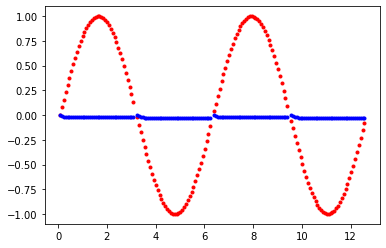

Loss:  0.4609872102737427


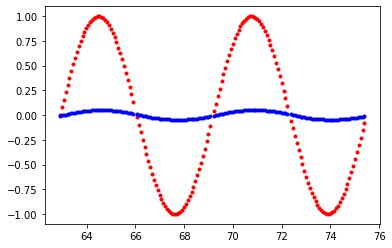

Loss:  0.4181082844734192


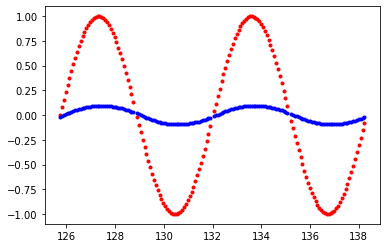

Loss:  0.36178886890411377


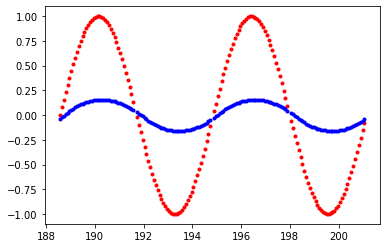

Loss:  0.2773383855819702


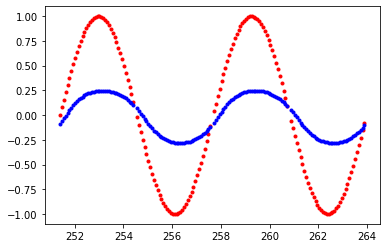

Loss:  0.17932887375354767


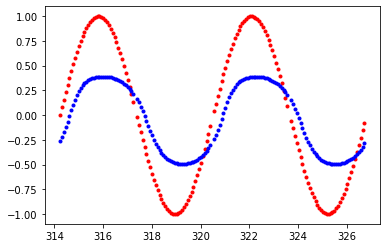

Loss:  0.13978910446166992


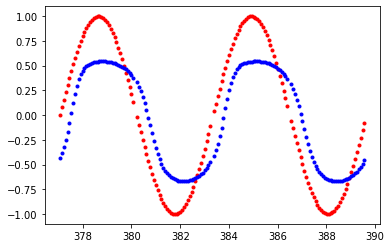

Loss:  0.10220665484666824


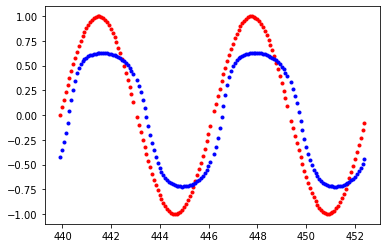

Loss:  0.06888024508953094


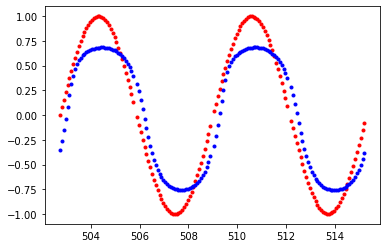

Loss:  0.04345827177166939


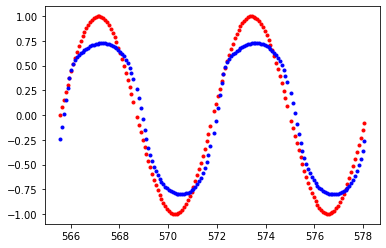

Loss:  0.02543712593615055


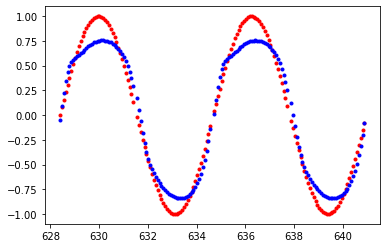

Loss:  0.017713645473122597


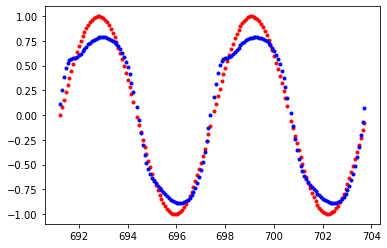

Loss:  0.015558784827589989


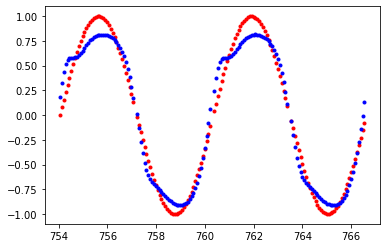

Loss:  0.012661793269217014


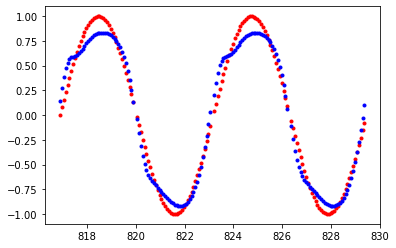

Loss:  0.009753944352269173


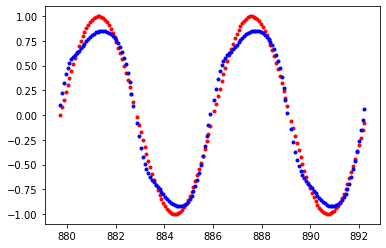

In [8]:
# train the rnn and monitor results
n_steps = 300
print_every = 20
clip=2
batch_size = times_pi

trained_rnn = train(lstm, batch_size, clip, n_steps, print_every)

Loss:  0.03128255531191826


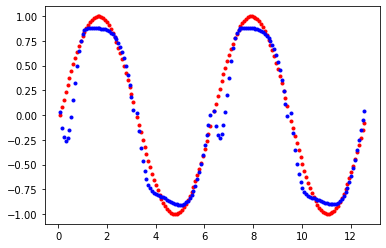

Loss:  0.002132101682946086


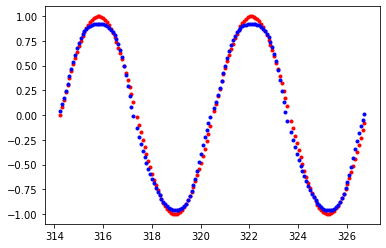

Loss:  0.000963930506259203


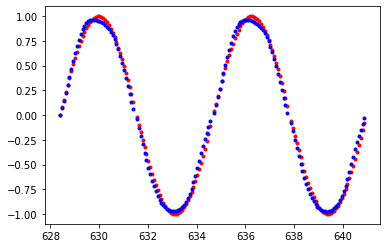

In [9]:
n_steps = 300
print_every = 100
clip=2

trained_rnn = train(lstm, batch_size, clip, n_steps, print_every)

---
## Inference

One thing to see what we learned is always doing inference, let's first prepare data for one example, and visualise the target we want to have

In [10]:
time_steps = np.linspace(0, np.pi, seq_length+1)
data = np.sin(time_steps)

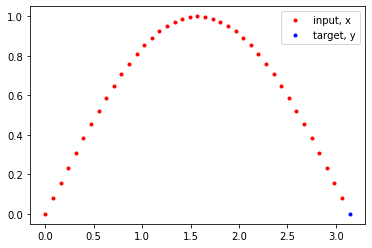

In [11]:
x = data[:-1] # all but the last piece of data
y = data[-1] # all but the first

# display the data
plt.plot(time_steps[:-1], x, 'r.', label='input, x') # x
plt.plot(time_steps[-1], y, 'b.', label='target, y') # y

plt.legend(loc='best')
plt.show()

### Performing inference

For performing inference the data must be in the format `(batch_size, seq_lenght, channels)`, so we reshape for it. We then convert it into a tensor and move it onto the GPU if available.

Performing inference is simply then calling the LSTM, and getting the last output. We visualise that result

In [22]:
xt = x.reshape(1,seq_length,1)

In [23]:
xt.shape

(1, 40, 1)

In [24]:
xt = torch.Tensor(xt).cuda() if train_on_gpu else torch.Tensor(xt)

In [31]:
predicted, hidden = lstm(xt, lstm.init_hidden(1))
predicted = predicted.detach().numpy()

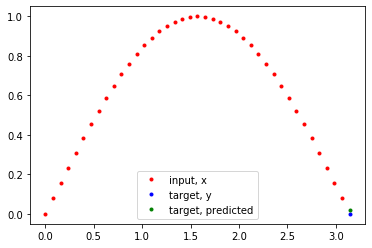

In [33]:
x = data[:-1] # all but the last piece of data
y = data[-1] # all but the first

# display the data
plt.plot(time_steps[:-1], x, 'r.', label='input, x') # x
plt.plot(time_steps[-1], y, 'b.', label='target, y') # y
plt.plot(time_steps[-1], predicted[-1], 'g.', label='target, predicted') # predicted

plt.legend(loc='best')
plt.show()

---
## Visualize the forget gate

We found that each past `cell state` of the LSTM has a forget gate, which decides how much to keep from the past event in each time step. When we have an LSTM it is easy to visualise this information

In [34]:
state = lstm.state_dict()
print(state)

OrderedDict([('lstm.weight_ih_l0', tensor([[-0.0773],
        [ 0.1263],
        [ 0.2284],
        [ 0.3089],
        [ 0.0861],
        [ 0.1104],
        [-0.3127],
        [ 0.1137],
        [ 0.1774],
        [-0.1162],
        [ 0.4274],
        [-0.0655],
        [-0.4534],
        [-0.3352],
        [-0.0567],
        [ 0.0501],
        [ 0.4477],
        [-0.2248],
        [ 0.2763],
        [-0.3639],
        [ 0.3378],
        [-0.1203],
        [ 0.0492],
        [-0.2513],
        [ 0.5494],
        [-0.1368],
        [ 0.1429],
        [ 0.5065],
        [-0.3714],
        [-0.5137],
        [-0.5644],
        [ 0.1792]])), ('lstm.weight_hh_l0', tensor([[ 0.0583, -0.1811,  0.1866, -0.2361,  0.1151, -0.2916, -0.4249,  0.1791],
        [ 0.0010,  0.2468, -0.2122, -0.0402,  0.0313,  0.0041, -0.1612, -0.3115],
        [ 0.1611, -0.1191,  0.1355, -0.4757, -0.2812, -0.4150,  0.0230,  0.1773],
        [ 0.0819, -0.0614,  0.2344,  0.0578,  0.1522, -0.2699, -0.1365,  0.3069],
    

Based on this really informative card about [LSTMs inner workings](https://www.gregcondit.com/articles/lstm-ref-card) we can extract the weights and biases form trained LSTMs state dict and redo the calculation

### Get the learned weights

In [35]:
#Event (x) Weights and Biases for all gates
Weights_xi = state['lstm.weight_ih_l0'][0:8].numpy()    # shape  [h, x]
Weights_xf = state['lstm.weight_ih_l0'][8:16].numpy()   # shape  [h, x]
Weights_xl = state['lstm.weight_ih_l0'][16:24].numpy()  # shape  [h, x]
Weights_xo = state['lstm.weight_ih_l0'][24:32].numpy()  # shape  [h, x]

Bias_xi = state['lstm.bias_ih_l0'][0:8].numpy()    #shape is [h, 1]
Bias_xf = state['lstm.bias_ih_l0'][8:16].numpy()   #shape is [h, 1]
Bias_xl = state['lstm.bias_ih_l0'][16:24].numpy()  #shape is [h, 1]
Bias_xo = state['lstm.bias_ih_l0'][24:32].numpy()  #shape is [h, 1]

#Hidden state (h) Weights and Biases for all gates
Weights_hi = state['lstm.weight_hh_l0'][0:8].numpy()    #shape is [h, h]
Weights_hf = state['lstm.weight_hh_l0'][8:16].numpy()   #shape is [h, h]
Weights_hl = state['lstm.weight_hh_l0'][16:24].numpy()  #shape is [h, h]
Weights_ho = state['lstm.weight_hh_l0'][24:32].numpy()  #shape is [h, h]

Bias_hi = state['lstm.bias_hh_l0'][0:8].numpy()    #shape is [h, 1]
Bias_hf = state['lstm.bias_hh_l0'][8:16].numpy()   #shape is [h, 1]
Bias_hl = state['lstm.bias_hh_l0'][16:24].numpy()  #shape is [h, 1]
Bias_ho = state['lstm.bias_hh_l0'][24:32].numpy()  #shape is [h, 1]

#--------------------------------------------------------------------
# Final, fully connected layer Weights and Bias
fc_Weight = state['fc.weight'][0].numpy() #shape is [h, output_size]
fc_Bias = state['fc.bias'][0].numpy() #shape is [,output_size]

### Set initial state to Zero

In [36]:
h = np.zeros(hidden_dim)
c = np.zeros(hidden_dim)

### Reimplementation of the gates simply in numpy

However, I modified the code to return the gates themselfes. For example, for the forget gate the original code was:

```python
def forget_gate(x, h, Weights_hf, Bias_hf, Weights_xf, Bias_xf, prev_cell_state):
    forget_hidden  = np.dot(Weights_hf, h) + Bias_hf
    forget_eventx  = np.dot(Weights_xf, x) + Bias_xf
    return np.multiply( sigmoid(forget_hidden + forget_eventx), prev_cell_state )
```

for our visualization, the gate (the `sigmoid(forget_hidden + forget_eventx)` is of interest, so the code changed to:

```python
def forget_gate(x, h, Weights_hf, Bias_hf, Weights_xf, Bias_xf, prev_cell_state):
    forget_hidden  = np.dot(Weights_hf, h) + Bias_hf
    forget_eventx  = np.dot(Weights_xf, x) + Bias_xf
    gate = sigmoid(forget_hidden + forget_eventx)
    return gate, np.multiply( gate, prev_cell_state )
```

and this is done for all the parts of the LSTM who employs a gate.

In [98]:
import numpy as np 
from scipy.special import expit as sigmoid

def forget_gate(x, h, Weights_hf, Bias_hf, Weights_xf, Bias_xf, prev_cell_state):
    forget_hidden  = np.dot(Weights_hf, h) + Bias_hf
    forget_eventx  = np.dot(Weights_xf, x) + Bias_xf
    gate = sigmoid(forget_hidden + forget_eventx)
    return gate, np.multiply( gate, prev_cell_state )

def input_gate(x, h, Weights_hi, Bias_hi, Weights_xi, Bias_xi, Weights_hl, Bias_hl, Weights_xl, Bias_xl):
    ignore_hidden  = np.dot(Weights_hi, h) + Bias_hi
    ignore_eventx  = np.dot(Weights_xi, x) + Bias_xi
    learn_hidden   = np.dot(Weights_hl, h) + Bias_hl
    learn_eventx   = np.dot(Weights_xl, x) + Bias_xl
    gate = sigmoid(ignore_eventx + ignore_hidden)
    return gate, np.multiply(gate , np.tanh(learn_eventx + learn_hidden) )


def cell_state(forget_gate_output, input_gate_output):
    return forget_gate_output + input_gate_output

  
def output_gate(x, h, Weights_ho, Bias_ho, Weights_xo, Bias_xo, cell_state):
    out_hidden = np.dot(Weights_ho, h) + Bias_ho
    out_eventx = np.dot(Weights_xo, x) + Bias_xo
    gate = sigmoid(out_eventx + out_hidden)
    return gate, np.multiply( gate, np.tanh(cell_state) )

def model_output(lstm_output, fc_Weight, fc_Bias):
    '''Takes the LSTM output and transforms it to our desired 
    output size using a final, fully connected layer'''
    return np.dot(fc_Weight, lstm_output) + fc_Bias

### We need the same hyperparameters as the trained LSTM

In [47]:
input_size  = 1 # size of one 'event', or sample, in our batch of data
hidden_dim  = 8 # 3 cells in the LSTM layer
output_size = 1 # desired model output

### Perform Inference:

We now perform inference. Our last point `h` must now be the same as `prediction[-1]`. Also, we keep all the gates activations during the execution to the last timestep, and use that for visualization

In [48]:
gates = []
for eventx in data:
    fg, f = forget_gate(eventx, h, Weights_hf, Bias_hf, Weights_xf, Bias_xf, c)
    ig, i =  input_gate(eventx, h, Weights_hi, Bias_hi, Weights_xi, Bias_xi, 
                    Weights_hl, Bias_hl, Weights_xl, Bias_xl)
    c = cell_state(f,i)
    hg, h = output_gate(eventx, h, Weights_ho, Bias_ho, Weights_xo, Bias_xo, c)
    gates.append((fg, ig , c, hg))

## Forget Gate in-depth

Let's see what we find out of the forget gate.

In [51]:
forget = np.array([f[0] for f in gates])

In [53]:
forget.shape

(41, 8, 8)

So, let's investigate the first state transition from $t_0$ to $t_1$ of the forget gate

In [60]:
forget[1]

array([[0.50451719, 0.53638384, 0.52488269, 0.53815493, 0.58134382,
        0.52508377, 0.47272503, 0.62132858],
       [0.5356974 , 0.48203257, 0.77668651, 0.61056836, 0.65251799,
        0.58199609, 0.65873026, 0.54860307],
       [0.53087812, 0.49161282, 0.76320298, 0.59048499, 0.61220009,
        0.57510939, 0.64813219, 0.56208108],
       [0.51896526, 0.48634528, 0.72101597, 0.58238164, 0.61200193,
        0.56473491, 0.61512134, 0.55962101],
       [0.52028043, 0.4795601 , 0.75130325, 0.58807678, 0.62046659,
        0.57077117, 0.63908223, 0.53750866],
       [0.54439417, 0.47837715, 0.80267634, 0.62331182, 0.67392707,
        0.58592767, 0.67629161, 0.5403382 ],
       [0.56769527, 0.53094323, 0.71810213, 0.61721183, 0.70091427,
        0.56002701, 0.59521   , 0.58522083],
       [0.52810526, 0.49933208, 0.69648472, 0.59494963, 0.64136893,
        0.57343675, 0.60182968, 0.56764944]])

In [61]:
forget[1,:,0]

array([0.50451719, 0.5356974 , 0.53087812, 0.51896526, 0.52028043,
       0.54439417, 0.56769527, 0.52810526])

In [107]:
for i in range(8):
    print(np.mean(forget[0,:,i]))

0.5285201323377073
0.49720454049403273
0.7165517292498054
0.5909458332748838
0.6345171204225764
0.5666653489863431
0.6111809043808452
0.5664962377529501


### Avarage keeping over all timesteps $t_x$

In [73]:
fm = [np.mean(f) for f in forget]

In [74]:
fm

[0.589010230862393,
 0.5905611780064464,
 0.5920318275808546,
 0.5930893718668035,
 0.5935259059596969,
 0.5932494604620956,
 0.5923130323077586,
 0.5908837389470051,
 0.589174396480184,
 0.587372382186738,
 0.5856058452957403,
 0.5839418989269424,
 0.5824043554305773,
 0.5809982254670903,
 0.5797206384998221,
 0.578565043007867,
 0.5775260052799807,
 0.5766023097151267,
 0.5757971041263447,
 0.5751159761584942,
 0.5745639860530763,
 0.5741426537751781,
 0.5738482077542536,
 0.5736719158076421,
 0.5736020085540046,
 0.5736259342619094,
 0.5737320029570676,
 0.5739102185619867,
 0.5741526105712473,
 0.5744535552192709,
 0.5748105638340824,
 0.5752259125752976,
 0.5757092818810803,
 0.5762812016552218,
 0.5769765426197222,
 0.5778466220661851,
 0.5789576262912157,
 0.5803816844830711,
 0.5821773476532699,
 0.584365890017612,
 0.5869232106208724]

In [75]:
min(fm)

0.5736020085540046

In [76]:
max(fm)

0.5935259059596969

In [78]:
norm_fm = np.array(fm) - 0.57

In [79]:
norm_fm

array([0.01901023, 0.02056118, 0.02203183, 0.02308937, 0.02352591,
       0.02324946, 0.02231303, 0.02088374, 0.0191744 , 0.01737238,
       0.01560585, 0.0139419 , 0.01240436, 0.01099823, 0.00972064,
       0.00856504, 0.00752601, 0.00660231, 0.0057971 , 0.00511598,
       0.00456399, 0.00414265, 0.00384821, 0.00367192, 0.00360201,
       0.00362593, 0.003732  , 0.00391022, 0.00415261, 0.00445356,
       0.00481056, 0.00522591, 0.00570928, 0.0062812 , 0.00697654,
       0.00784662, 0.00895763, 0.01038168, 0.01217735, 0.01436589,
       0.01692321])

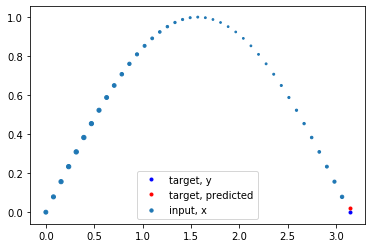

In [113]:
x = data[:-1] # all but the last piece of data
y = data[-1] # all but the first

# display the data
plt.scatter(time_steps[:-1], x, label='input, x', s=(norm_fm*800)) # x
plt.plot(time_steps[-1], y, 'b.', label='target, y') # y
plt.plot(time_steps[-1], predicted[-1], 'r.', label='target, predicted') # predicted

plt.legend(loc='best')
plt.show()